In [1]:
ls -a


./                      README.md               simple-GAN.ipynb
../                     assets/                 simple_gan_colab.ipynb
.DS_Store               data/                   train_samples.pkl
.git/                   notes.txt
.ipynb_checkpoints/     requirements.txt


In [0]:
!pip install -r requirements.txt

## Generative Adversarial Network

This notebook shows the example of a generative adversarial network (GAN) trained on the MNIST dataset. We can then take this GAN training network and generate new handwritten images.

The main idea is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator creates "fake" data to pass to the discriminator. The discriminator also sees the real training data and predicts whether the data he has seen is real or fake. 

> * The generator is trained to fool the discriminator and in doing so, it wants to output data that looks _as close as possible_ to real data. 
* The discriminator is a classifier that is trained to distinguish which data is real and which is fake. 


![GAN Pipeline](assets/gan_pipeline.png) 
What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator. 

The general pipeline of the GAN is shown above where the real data is MNIST images. The latent sample is a random vector that the generator uses to construct its fake images. This is called a **latent vector** and that vector space is called **latent space**. As the generator trains, it learns how to map latent vectors to recignizable images that can fool the discriminator. 

The output of a discriminator is a **sigmoid function** where 0 indicates a fake image and 1 indicates a real image.

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Define variables for data loading:

# number of subprocesses to use
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)

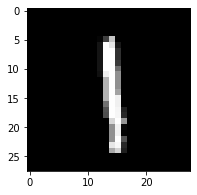

In [8]:
# Plot a sample image:

sample_ix = 8

# get one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[sample_ix])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## The model

A GAN consists of two adversarial networks, a discriminator and a generator.

<img src = 'gan_network.png' width = 70% />


### Generator network

The input to the generator is *z*, which is a random noise vector. The generator then learns how to convert this vector into an image. To make this network a universal function approximator, we need at least one hidden layer. These hidden layers should have a **leaky ReLu** activation function applied to their output. A leaky ReLU is very similar to the normal ReLu except that there is a small, non-zero output when input is negative. 

After the final hidden layer in the generator we have a **tanh** activation function.  The generator has been found to perform the best with *tanh* for the generator output. Recall that *tanh* function squishes the output into the range [-1, 1].



### Discriminator network

Since the output from *tanh* is bounded by [-1, 1], we also have to rescale our images from [0, 1] to [-1, 1]. We feed both images and *tanh* output to the hidden layer.

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0 or 1 indicating whether an image is real or fake. Therefore, we will ultimately use **BCEWithLogitsLoss**, which combines a sigmoid activation function and and binary cross entropy loss in one function.


In [0]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        """
        Builds the discriminator network. 
        Parameters
        ----------
        input_size : int
        Size of the input image to the discriminator
        hidden_dim : int
        Size of the last hidden layer in the discriminator
        output_size : int
        Size of discriminator output (real or fake?)

        Returns
        -------
        out : Pytorch object for the discriminator model

        """
        # hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        """
        Builds the generator network. 
        Parameters
        ----------
        input_size : int
        Size of the latent vector that is fed to the generator
        hidden_dim : int
        Size of the first hidden layer in the generator
        output_size : int
        Size of discriminator output (generated image)

        Returns
        -------
        out : Pytorch object for the generator model

        """
        # hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

In [0]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [12]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [0]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [16]:
import pickle as pkl

# training hyperparams
num_epochs = 10

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   10] | d_loss: 1.1701 | g_loss: 1.0802
Epoch [    1/   10] | d_loss: 0.9649 | g_loss: 2.8809
Epoch [    1/   10] | d_loss: 0.9840 | g_loss: 2.0026
Epoch [    2/   10] | d_loss: 1.0506 | g_loss: 2.2020
Epoch [    2/   10] | d_loss: 1.1275 | g_loss: 1.8882
Epoch [    2/   10] | d_loss: 1.4939 | g_loss: 0.9995
Epoch [    3/   10] | d_loss: 1.3475 | g_loss: 1.0348
Epoch [    3/   10] | d_loss: 1.0149 | g_loss: 2.1101
Epoch [    3/   10] | d_loss: 1.2358 | g_loss: 1.3539
Epoch [    4/   10] | d_loss: 1.1917 | g_loss: 1.0793
Epoch [    4/   10] | d_loss: 1.0792 | g_loss: 1.7521
Epoch [    4/   10] | d_loss: 1.2738 | g_loss: 0.8761
Epoch [    5/   10] | d_loss: 1.3333 | g_loss: 0.8752
Epoch [    5/   10] | d_loss: 1.1480 | g_loss: 0.9865
Epoch [    5/   10] | d_loss: 1.3820 | g_loss: 1.0918
Epoch [    6/   10] | d_loss: 1.1287 | g_loss: 1.3531
Epoch [    6/   10] | d_loss: 1.1478 | g_loss: 1.0327
Epoch [    6/   10] | d_loss: 1.3387 | g_loss: 1.0650
Epoch [    7/   10] | d_loss

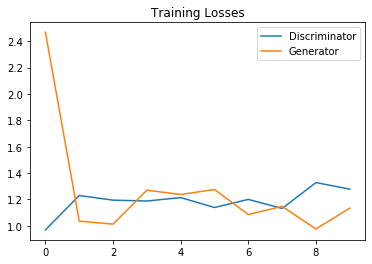

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

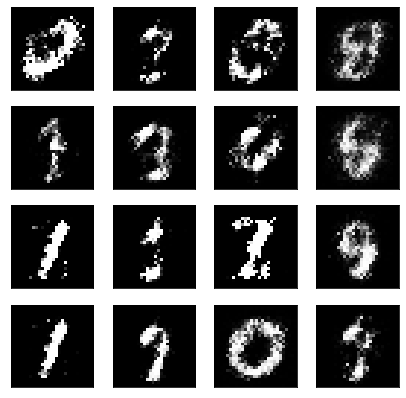

In [20]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

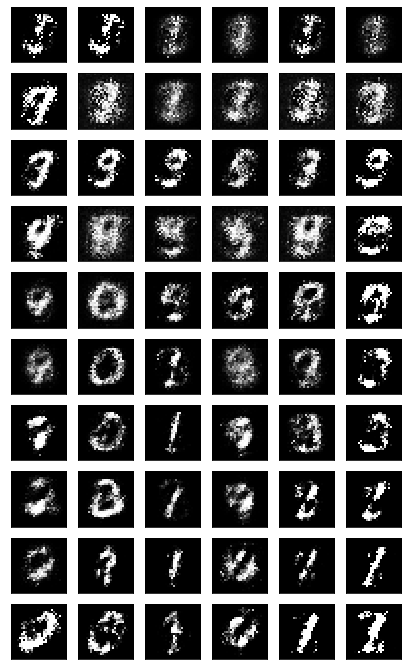

In [21]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


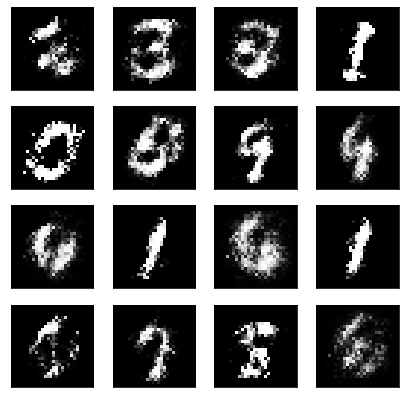

In [22]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])